Обучение Ridge-модели на синтетических данных с последующим итерационным уточнением предсказаний по обратной связи с MSE на тестовых данных  
Итоговый [контест](https://contest.yandex.ru/contest/56809/problems/) [Яндекс ML тренировок](https://yandex.ru/yaintern/training/ml-training).

Содержание:

1. Baseline  
    - EDA по исходным данным контеста

2. Свой датасет с похожими свойствами
    - EDA по синтетическим данным
    - Математическое описание алгоритма
    - Код

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

RANDOM_SEED = 42

In [2]:
def score1(mse):
    return max([np.round((1 - mse) * 1.5, 2), 0])

def print_errors(model, x_tr, y_tr, x_tst, y_tst, score=score1, valid_name='val'):
    train_mse = mean_squared_error(np.round(model.predict(x_tr), 2), np.round(y_tr, 2))
    val_mse = mean_squared_error(np.round(model.predict(x_tst), 2), np.round(y_tst, 2))
    val_score = score(val_mse)
    print(f"train mse / {valid_name} mse = \t{train_mse:.5f} / {val_mse:.5f} \t test score = {val_score}")
    return train_mse, val_mse, val_score

### Baseline

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_open_data.npy -O hw_final_open_data.npy
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_open_target.npy -O hw_final_open_data.npy
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_closed_data.npy -O hw_final_closed_data.npy

In [4]:
data = np.load('hw_final_open_data.npy', allow_pickle=False)
target = np.load('hw_final_open_target.npy', allow_pickle=False)
closed_data = np.load('hw_final_closed_data.npy', allow_pickle=False)

# для простоты оставим несколько фич
to_drop = [2, 5, 6, ]
data = np.delete(arr=data, obj=to_drop, axis=1)

In [4]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
df = pd.DataFrame(np.hstack((data_scaled, target.reshape(-1, 1))))
df.corr()

,0,1,2,3,4
0,1.000000,0.937960,0.966040,0.994517,0.939754
1,0.937960,1.000000,0.995510,0.968657,0.990131
2,0.966040,0.995510,1.000000,0.987662,0.988741
3,0.994517,0.968657,0.987662,1.000000,0.967082
4,0.939754,0.990131,0.988741,0.967082,1.000000


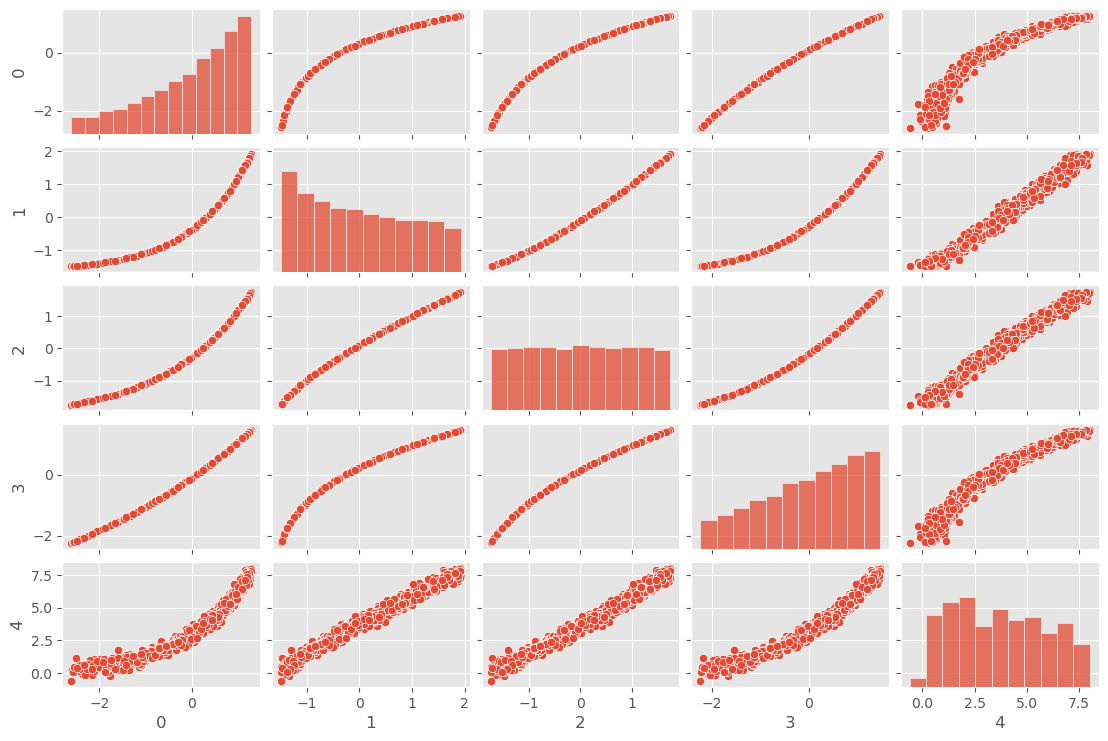

In [5]:
sns.pairplot(df, diag_kind="hist", height=1.5, aspect=1.5);

In [6]:
train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.2, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(train_x)
X_valid = scaler.transform(valid_x)

model = Ridge(random_state=RANDOM_SEED, alpha=1e-3)
model.fit(X_train, train_y)
_ = print_errors(model, X_train, train_y, X_valid, valid_y)

train mse / val mse = 	0.08851 / 0.09520 	 test score = 1.36


### Свой датасет с похожими свойствами

In [6]:
N_SAMPLES, N_FEATURES = data.shape
# выберем небольшой шум
NOISE_STD = 0.3

rng = np.random.default_rng(RANDOM_SEED)
noise = rng.normal(loc=0, scale=NOISE_STD, size=N_SAMPLES).reshape(-1, 1)

# фичи подбираем вручную чтобы корреляции и распределения выглядели похоже на исходный датасет
x2 = np.array(range(N_SAMPLES)).reshape(-1, 1) / N_SAMPLES
x0 = x2 ** 0.4
x1 = x2 ** 1.5
x3 = x2 ** 0.5
target_synth = (x0 + x1 + x2 + x3 + noise)
data_synth = np.hstack((x0, x1, x2, x3))

In [7]:
scaler = StandardScaler()
data_synth_scaled = scaler.fit_transform(data_synth)
df_synth = pd.DataFrame(np.hstack((data_synth_scaled, target_synth)))
df_synth.corr()

,0,1,2,3,4
0,1.000000,0.924138,0.967430,0.998509,0.942520
1,0.924138,1.000000,0.989709,0.942238,0.942285
2,0.967430,0.989709,1.000000,0.979453,0.958988
3,0.998509,0.942238,0.979453,1.000000,0.950879
4,0.942520,0.942285,0.958988,0.950879,1.000000


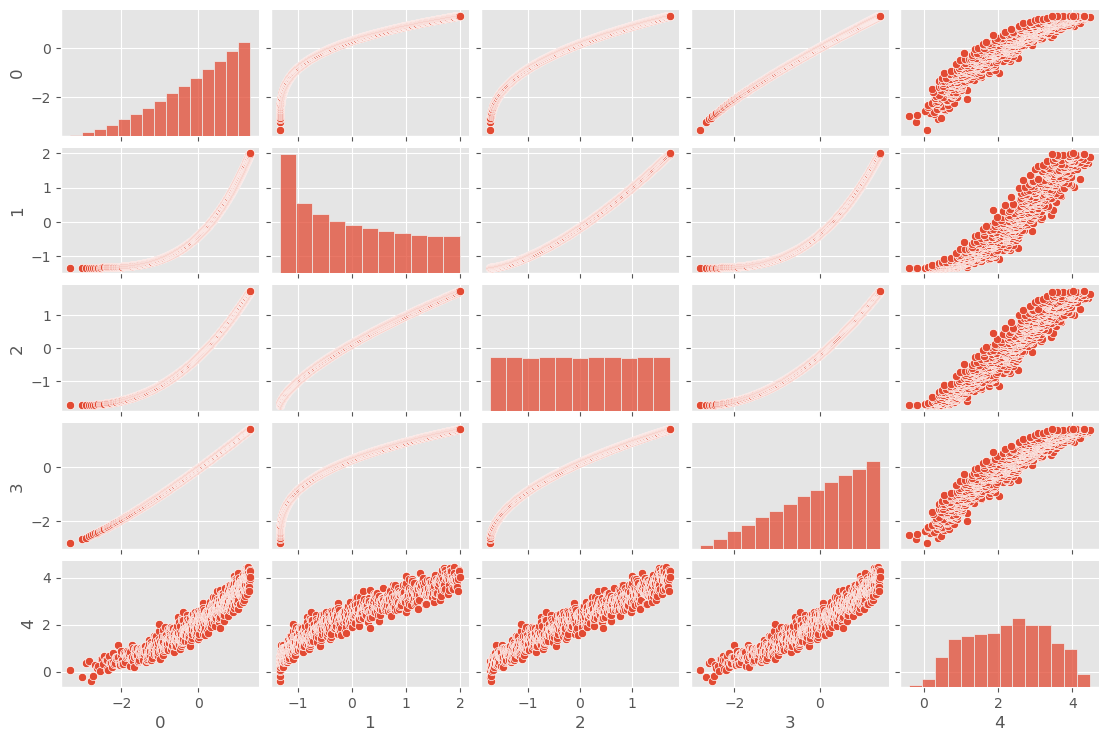

In [8]:
sns.pairplot(df_synth, diag_kind="hist", height=1.5, aspect=1.5);

Сделаем baseline

In [9]:
train_x, valid_x, train_y, valid_y = train_test_split(data_synth, target_synth, test_size=0.2, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(train_x)
X_valid = scaler.transform(valid_x)

model = Ridge(random_state=RANDOM_SEED, alpha=1e-3)
model.fit(X_train, train_y)
_ = print_errors(model, X_train, train_y, X_valid, valid_y)

train mse / val mse = 	0.08608 / 0.09120 	 test score = 1.36


Визуально картинки более менее похожи. Наша цель посмотреть как можно (и можно ли вообще)) зафиттится на мсе из тестового сета. Перейдем к следующему шагу

Отложим последние 200 точек в качестве тестового сета

In [10]:
N_TEST_SAMPLES = 200

data_test = data_synth[-N_TEST_SAMPLES :]
target_test = target_synth[-N_TEST_SAMPLES :]

data_train = data_synth[: N_SAMPLES]
target_train = target_synth[: N_SAMPLES]

assert (data_test[:10] == data_synth[-N_TEST_SAMPLES : len(data_synth) - N_TEST_SAMPLES + 10]).all()
assert (target_test[:10] == target_synth[-N_TEST_SAMPLES : len(target_synth) - N_TEST_SAMPLES + 10]).all()
assert (data_test[-10:] == data_synth[-10 :]).all()
assert (target_test[-10:] == target_synth[-10 :]).all()

assert (data_train[:10] == data_synth[: 10]).all()
assert (target_train[:10] == target_synth[: 10]).all()
assert (data_train[-10:] == data_synth[-10:]).all()
assert (target_train[-10:] == target_synth[-10:]).all()

Baseline model

In [11]:
train_x, valid_x, train_y, valid_y = train_test_split(data_train, target_train, test_size=0.2, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(train_x)
X_valid = scaler.transform(valid_x)
X_test = scaler.transform(data_test)

model = Ridge(random_state=RANDOM_SEED, alpha=1e-3)
model.fit(X_train, train_y)
_ = print_errors(model, X_train, train_y, X_valid, valid_y)
_ = print_errors(model, X_train, train_y, X_test, target_test, valid_name='test')

train mse / val mse = 	0.08608 / 0.09120 	 test score = 1.36
train mse / test mse = 	0.08608 / 0.09283 	 test score = 1.36


Теперь итеративно будем фиттится на мсе по таргетам из тестового датасета

_Математическая постановка_:  

Пусть $\tilde{y}$ - целевой таргет, $y$ - предсказанное значение, полученное предиктом обученной на тренировочном датасете модели.

По определению $MSE = \sum_{i=1}^{m}(y_i - \tilde{y}_i)^2$. Тогда   
$$
\Delta{MSE} = \sum_{j}\frac{\partial {MSE}}{\partial y_j}\Delta y_j + \frac{1}{2} \sum_{j}\frac{\partial^2 {MSE}}{\partial {y_j}^2}\Delta y_j^2 + o(\Delta^2 y_j)\,,
$$

где

$$
\frac{\partial {MSE}}{\partial {y_j}} = 2\,(y_j - \tilde{y}_j)\,,\,\frac{\partial^2 {MSE}}{\partial {y_j}^2} = 2\,.
$$

Обозначим через ${MSE}^{*}$ значение MSE, полученное из контеста при сабмите предиктов $y$. Тогда также будет справедливо
$$
\Delta{MSE}^{*} = \sum_{j}\frac{\partial {MSE}^{*}}{\partial y_j}\Delta y_j + \frac{1}{2} \sum_{j}\frac{\partial^2 {MSE}^{*}}{\partial {y_j}^2}\Delta y_j^2 + o(\Delta^2 y_j)\,.
$$

Далее итерируемся по компонентам $y_{j}$ и полагаем $\Delta y_j = 0\,,\,j\ne n$. 
Тогда 
$$
\sum_{j}\frac{\partial {MSE}_{*}}{\partial y_j}\Delta y_j = \frac{\partial {MSE}_{*}}{\partial y_n}\Delta y_n
 = 2\,(y_n - \tilde{y}_n) \Delta y_n
$$
и
$$
\sum_{j}\frac{\partial^2 {MSE}_{*}}{\partial {y_j}^2}\Delta^2 y_j = \frac{\partial^2 {MSE}_{*}}{\partial {y_n}^2}\Delta^2 y_n
 = 2\,\Delta^2{y_n}\,.
$$

Так как остаточные члены $o(\Delta^2{y_n}) = 0$, то исходное соотношение принимает вид:
$$
\Delta{MSE}^{*} = 2\,(y_n - \tilde{y}_n)\Delta y_n + \Delta^2 y_n\,.
$$

Точное значение для таргета $\tilde{y}_n$ принимает вид:
$$
\tilde{y}_n = y_n + \frac{1}{2}\Delta{y_n} - \frac{\Delta {MSE}^{*}}{2\,\Delta{y_n}}.
$$

Далее используем $\Delta y_n = \text{const} = d$. Учитывая, что mse считается для m точек, вводим масштабирующий коеффициент и итоговая формула для точного значения целевой переменной принимает вид:
$$
\tilde{y}_n = y_n + \frac{1}{2}\,d - \frac{m\,\Delta{MSE}^{*}}{2\,d}.
$$


In [22]:
def get_contest_score(y, target):
    return mean_squared_error(np.round(y, 2), np.round(target, 2))

mse = 0.0029, score = 1.50


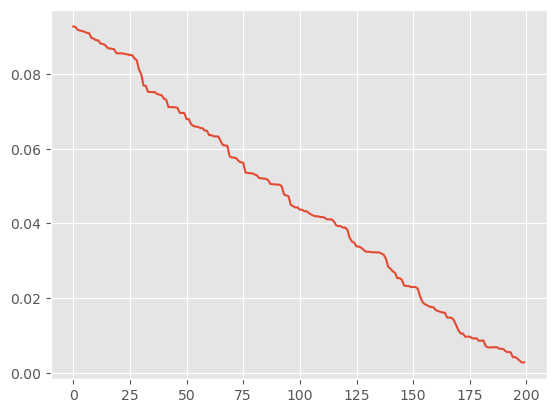

In [48]:
DELTA = 100
hist_score = []

y = model.predict(X_test)
score_base = get_contest_score(y, target_test)
for n in range(200):
    y[n] += DELTA
    score_new = get_contest_score(y, target_test)
    d_score = score_new - score_base        
    y[n] -= DELTA    
    y[n] += 0.5 * DELTA - N_TEST_SAMPLES * d_score / (2 * DELTA)
    hist_score.append((d_score, get_contest_score(y, target_test)))

final_mse = get_contest_score(y, target_test)
print(f"mse = {final_mse:.4f}, score = {score1(final_mse):.2f}")
plt.plot([x[-1] for x in hist_score]);